In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from IPython.display import display

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import RobustScaler, Normalizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import KFold

In [2]:
path_train = 'train.csv'
data = pd.read_csv(path_train)
data_no_na = data.dropna(axis=0, subset=['fixed acidity', 'volatile acidity', 'pH', 'sulphates'])
only_na = data[~data.index.isin(data_no_na.index)]
data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)
no_duplicates = data_no_na.drop_duplicates(keep='first')
only_duplicates = data_no_na[~data_no_na.index.isin(no_duplicates.index)]
train_data, test_data, train_target, target_test = train_test_split(no_duplicates.drop(axis=1, columns=['wine_class']), pd.DataFrame(no_duplicates.wine_class), test_size=0.3, stratify=pd.DataFrame(no_duplicates.quality), shuffle=True)
z = stats.zscore(train_data)
train_data_clean = train_data.drop(axis=1, columns=['citric acid', 'pH', 'free sulfur dioxide'])[~(np.abs(z) > 3).any(axis=1)]
#.drop(axis=1, columns=['citric acid'])
numeric_columns = train_data_clean.select_dtypes(include=['float64', 'uint64', 'int64'])

C:\Users\Arseny\AppData\Local\Temp\ipykernel_20620\2156841259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)


In [3]:
train_data_clean.reset_index(inplace=True, drop=True)
target_train = pd.DataFrame(train_data_clean['quality'].apply(lambda x: 0 if x < 7 else 1))
features_train = train_data_clean.drop(axis=1, columns=['quality'])
features_test = test_data.drop(axis=1, columns=['quality', 'citric acid', 'pH', 'free sulfur dioxide'])
# .drop(axis=1, columns=['quality', 'citric acid'])

In [4]:
cv = KFold(n_splits=7, shuffle=True)
pipe_logreg = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression())])

#шаблон контейнера
penalty=['l2']
solver=['lbfgs']
C=np.array([0.1, 0.7, 0.8, 0.9, 1, 3, 5, 10])
max_iter=[100, 200, 300, 400, 500, 600, 700, 1000]


param_grid =[
    {'preprocessing': [MinMaxScaler(), StandardScaler(), RobustScaler()], 
     'classifier': [LogisticRegression()],
     'classifier__C': C,
     'classifier__penalty': penalty,
     'classifier__solver': solver, 
     'classifier__max_iter': max_iter
     }
]

grid = GridSearchCV(pipe_logreg, param_grid, cv=cv, return_train_score=True, n_jobs=-2, scoring='precision', error_score="raise")
grid.fit(features_train, target_train)

print("----------------- Обучили и тестировали -------------------")
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на \
                валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
# print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid.precision_score(grid.predict(features_test), target_test)))
gridresults = pd.DataFrame(grid.cv_results_) #лучшая опция по кроссвалидации
display(gridresults.sort_values(["rank_test_score"]).T)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


----------------- Обучили и тестировали -------------------
Наилучшие параметры:
{'classifier': LogisticRegression(), 'classifier__C': 0.9, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'preprocessing': MinMaxScaler()}

Средняя правильность для наилучшей модели кроссвалидации на                 валидационных тестовых наборах: 0.738095



,75,81,84,87,90,93,78,72,102,96,...,69,48,21,18,15,12,9,6,3,0
mean_fit_time,0.033155,0.034182,0.040597,0.033829,0.037143,0.027222,0.034631,0.035767,0.029757,0.027681,...,0.034109,0.030531,0.026587,0.026908,0.027544,0.030709,0.027153,0.030789,0.029814,0.082932
std_fit_time,0.003352,0.003508,0.009962,0.002469,0.006717,0.000755,0.006437,0.006866,0.003699,0.002432,...,0.008468,0.003899,0.001263,0.002511,0.001716,0.006359,0.001747,0.007713,0.001392,0.003874
mean_score_time,0.036133,0.036281,0.04101,0.03348,0.038296,0.026503,0.033313,0.036477,0.027658,0.031155,...,0.03216,0.031355,0.030763,0.031456,0.033998,0.036248,0.03444,0.036546,0.034883,0.049514
std_score_time,0.006328,0.009078,0.008214,0.005908,0.014171,0.002731,0.002526,0.007696,0.002343,0.005891,...,0.002922,0.002929,0.002729,0.001734,0.009031,0.01126,0.006284,0.007492,0.004917,0.007356
param_classifier,LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),...,LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression()
param_classifier__C,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,1.0,1.0,...,0.8,0.8,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
param_classifier__max_iter,200,400,500,600,700,1000,300,100,300,100,...,1000,100,1000,700,600,500,400,300,200,100
param_classifier__penalty,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,...,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2
param_classifier__solver,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,...,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs
param_preprocessing,MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),...,MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler()


Правильность для наилучшей модели на тестовом наборе: 0.666667



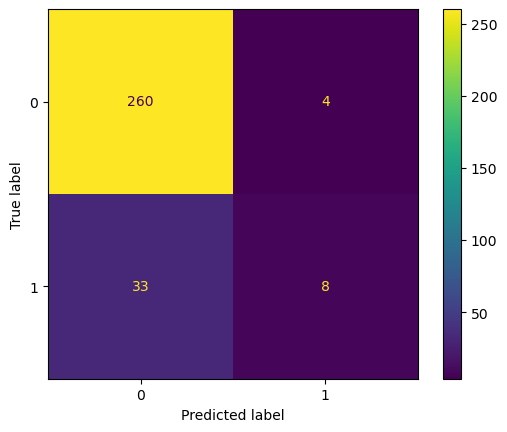

In [5]:
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(precision_score(target_test, grid.predict(features_test))))
matrix = confusion_matrix(target_test, grid.predict(features_test))
ConfusionMatrixDisplay(matrix).plot()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Правильность модели на тестовом наборе: 0.615385

recall:  0.244  precision:, 0.455  thresholds:,0.458
recall:  0.195  precision:, 0.615  thresholds:,0.504


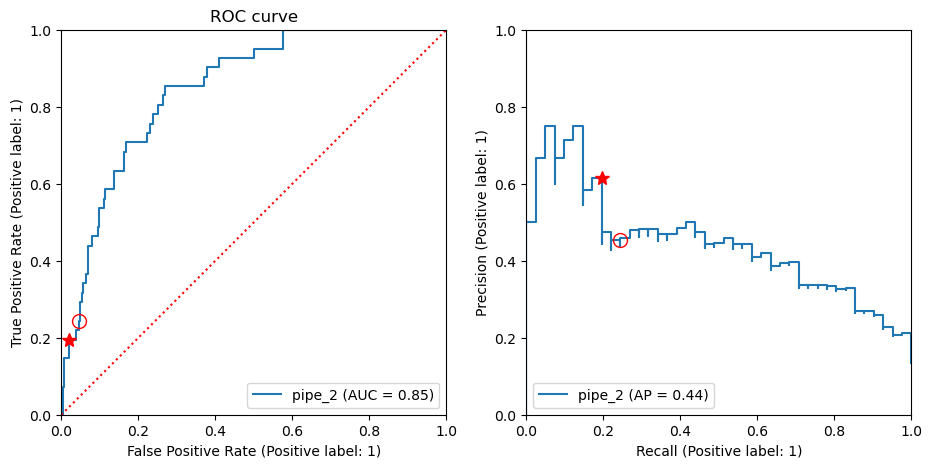

In [9]:
pipe_1 = make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l2', C=0.9, solver='liblinear', max_iter=100))
pipe_1.fit(features_train,target_train)
print("Правильность модели на тестовом наборе: {:.6f}\n".format(precision_score(target_test, pipe_1.predict(features_test))))


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
fpr, tpr, thresholds = roc_curve(target_test, pipe_1.predict_proba(features_test)[:,1], pos_label = None)
pos = 10
point = find_nearest(thresholds,0.5)
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11, 5))
RocCurveDisplay.from_estimator(pipe_1, features_test, target_test, name = 'pipe_2', ax=ax1)
ax1.set_title("ROC curve")
ax1.plot([0,1],[0,1], color="r", ls=":")
ax1.plot(fpr[point],tpr[point], '*', markersize=10, color="r")
ax1.plot(fpr[pos],tpr[pos], 'o', markersize=10,  mfc='none', color="r");
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))
precision, recall, thresholds_pr = precision_recall_curve(target_test, pipe_1.predict_proba(features_test)[:,1], pos_label = None)
PrecisionRecallDisplay.from_estimator(pipe_1, features_test, target_test, name = 'pipe_2', ax=ax2)
point_pr = find_nearest(thresholds_pr,0.5)
pos_pr = find_nearest(thresholds_pr,thresholds[pos])
ax2.plot(recall[point_pr],precision[point_pr], '*', markersize=10, color="r")
ax2.plot(recall[pos_pr],precision[pos_pr], 'o', markersize=10,  mfc='none', color="r");
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))
print( f'recall:  {recall[pos_pr]:.3f}', f' precision:, {precision[pos_pr]:.3f}', f' thresholds:,{thresholds[pos]:.3f}')
print( f'recall:  {recall[point_pr]:.3f}', f' precision:, {precision[point_pr]:.3f}', f' thresholds:,{thresholds[point]:.3f}')

In [7]:
# def custom_predict(X, threshold):
#     probs = model.predict_proba(X) 
#     return (probs[:, 1] > threshold).astype(int)
    
    
# new_preds = custom_predict(X=X, threshold=0.4) 

1) В случае если мы не делаем чисту выбросов, но удаляем citric acid, то в 12 pose получается 0.75 0.44
2) В случае если мы не дропаем, то в pos=10 получается 0.78, 0.44
3) Пока лучше всего работает с neighbors=30, p=4, weight='distance'